In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Deep Convolutional GAN (DCGAN) Implementation with MNIST using PyTorch

This guide will walk you through the implementation of a Deep Convolutional GAN (DCGAN) using PyTorch. DCGANs are a class of generative adversarial networks (GANs) specifically designed for generating high-quality images.


# Some Theory

## Generative Adversial Networks (GANs)

Generative Adversarial Networks (GANs) are a class of deep learning models introduced by Ian Goodfellow and his colleagues in 2014. GANs consist of two neural networks, the Generator and the Discriminator, trained simultaneously through a competitive process.

- Generator: The Generator takes random noice as input and generates synthetic data samples, such as images
- Discriminator: Binary Classifier that distinguishes between real data and fake data generated by Generator

# Deep Convolutional GANs (DCGANs)

Deep Convolutional GANs (DCGANs) are a variant of GANs proposed by Alec Radford, Luke Metz, and Soumith Chintala in 2015. DCGANs introduce architectural guidelines and best practices for designing both the Generator and Discriminator networks, specifically tailored for generating high-quality images.

### Key characteristics of DCGANs include:

- Convolutional Networks: Both the Generator and Discriminator are based on convolutional neural networks (CNNs), which are well-suited for image processing tasks.

- Strided Convolutions and Fractional Strided Convolutions: DCGANs use strided convolutions in the Generator to upsample the input noise, and fractional strided (transpose) convolutions in the Discriminator to downsample the image.

- Batch Normalization: Batch normalization is applied in both the Generator and Discriminator to stabilize and accelerate training.

- No Fully Connected Layers: DCGANs avoid the use of fully connected layers in favor of global average pooling in the Discriminator and fully convolutional architectures in the Generator.

# Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [3]:
torch.cuda.is_available()

False

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Hyper-parameters
latent_size = 100
hidden_size = 64
image_size = 784
num_epochs = 50
batch_size = 100
sample_dir = 'samples'

In [6]:
import os
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [7]:
# Imprting MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

mnist = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 83488213.94it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37135405.83it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20566299.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8079104.65it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Generator

The Generator consists of several layers of transposed convolutions (also known as fractionally-strided convolutions) interleaved with batch normalization and ReLU activation functions. It gradually upsamples the input noise vector into a synthetic image.

- nz - size of the input noice vector (latent vector)
- ngf - number of features. This parameter controls the complexity of the network
- nc - Number of channels in the output image (3 for RGB images), 1 for MNIST dataset

In [8]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()).to(device)

# Discriminator

The Discriminator is responsible for distinguishing between real and fake images generated by the Generator.

- We define the Discriminator class, which takes an input image (real or fake) and outputs a probability indicating whether the input image is real or fake.
- The architecture consists of convolutional layers with leaky ReLU activation functions, followed by a Sigmoid activation function in the output layer to produce a probability score between 0 and 1.
The discriminator's output size will be a single scalar value representing the probability of the input image being real.

In [9]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()).to(device)

In [10]:
# Device setting
D = D.to(device)
G = G.to(device)

# Setting Loss Function

- In a GAN setup, the Generator aims to minimize the probability of the Discriminator correctly classifying its generated images as fake (i.e., maximizing log(D(G(z)))).
- The Discriminator aims to correctly classify real and fake images, so it minimizes the difference between its predictions and the ground truth labels.
- Typically, GANs use the Binary Cross Entropy Loss (BCELoss) for both the Generator and Discriminator.

In [11]:
criterion = nn.BCELoss()

### Define Optimizers

Adam is commonly used for this. Each optimizer will update the parameters of its respective network during training

In [12]:
import torch.optim as optim

d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

#### Trining loop

- Iterate over the dataset in batches.
- Generate fake images uing Generator.
- Train the Discriminator on both real and fake images.
- Train the Generator to fool the Discriminator

In [13]:
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.to(device)
        images = images.view(batch_size, -1)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        g_loss = criterion(outputs, real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))

    if (epoch+1) == 1:
        images = images.view(images.size(0), 1, 28, 28)
        save_image(images, os.path.join(sample_dir, 'real_images.png'))

    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    save_image(fake_images, os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')


Epoch [0/50], Step [200/600], d_loss: 0.5023, g_loss: 1.2341, D(x): 0.93, D(G(z)): 0.35
Epoch [0/50], Step [400/600], d_loss: 0.2551, g_loss: 1.8173, D(x): 0.96, D(G(z)): 0.19
Epoch [0/50], Step [600/600], d_loss: 0.2789, g_loss: 1.9877, D(x): 0.96, D(G(z)): 0.21
Epoch [1/50], Step [200/600], d_loss: 0.0953, g_loss: 3.1376, D(x): 0.97, D(G(z)): 0.06
Epoch [1/50], Step [400/600], d_loss: 0.3502, g_loss: 2.1619, D(x): 0.89, D(G(z)): 0.19
Epoch [1/50], Step [600/600], d_loss: 0.4478, g_loss: 3.0334, D(x): 0.84, D(G(z)): 0.17
Epoch [2/50], Step [200/600], d_loss: 0.3712, g_loss: 2.2500, D(x): 0.83, D(G(z)): 0.15
Epoch [2/50], Step [400/600], d_loss: 0.1562, g_loss: 3.2493, D(x): 0.95, D(G(z)): 0.09
Epoch [2/50], Step [600/600], d_loss: 0.8049, g_loss: 2.7913, D(x): 0.76, D(G(z)): 0.27
Epoch [3/50], Step [200/600], d_loss: 0.1157, g_loss: 3.4065, D(x): 0.97, D(G(z)): 0.07
Epoch [3/50], Step [400/600], d_loss: 0.3253, g_loss: 3.5003, D(x): 0.83, D(G(z)): 0.08
Epoch [3/50], Step [600/600], d_

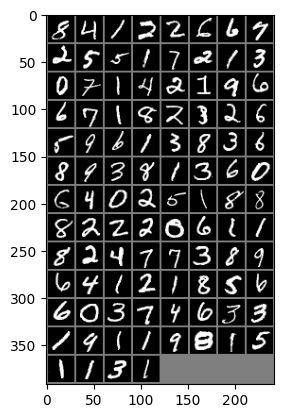

Labels: tensor([8, 4, 1, 2, 2, 6, 6, 7, 2, 5, 5, 1, 7, 2, 1, 3, 0, 7, 1, 4, 2, 1, 9, 6,
        6, 7, 1, 8, 2, 3, 2, 6, 5, 9, 6, 1, 3, 8, 3, 6, 8, 9, 3, 8, 1, 3, 6, 0,
        6, 4, 0, 2, 5, 1, 8, 8, 8, 2, 2, 2, 0, 6, 1, 1, 8, 2, 4, 7, 7, 3, 8, 9,
        6, 4, 1, 2, 1, 8, 5, 6, 6, 0, 3, 7, 4, 6, 3, 3, 1, 9, 1, 1, 9, 8, 1, 5,
        1, 1, 3, 1])


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(data_loader))

imshow(torchvision.utils.make_grid(images))
print('Labels:', labels)
